In [97]:
# Imports
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow.parquet as pq
from collections import Counter
from itertools import groupby
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [5]:
# Display options
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.options.mode.chained_assignment = None  # default='warn'

plt.rcParams["figure.figsize"] = (12, 8)
sns.set(style="whitegrid", color_codes=True)
sns.set_context("notebook", font_scale=1.2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Prepare orders data

In [6]:
# Read data
clients = pd.read_csv('./data/clients.csv')
materials = pd.read_csv('./data/materials.csv')
plants = pd.read_csv('./data/plants.csv')
transactions = pq.read_table('./data/transactions.parquet')
transactions = transactions.to_pandas()

In [7]:
# Size info
def ss(df):
    print(df.shape)
    print(df.memory_usage(deep=True).sum()/10**9, 'Gb')

In [8]:
ss(transactions)

(32109414, 9)
14.401458318 Gb


In [9]:
# Merge data
clients.columns = ['client_id', 'client_gender', 
                   'client_city', 'client_birthyear']
materials.columns = ['material', 'material_hier_level_1', 
                     'material_hier_level_2', 'material_hier_level_3', 
                     'material_hier_level_4', 'material_vendor', 
                     'material_is_private_label', 'material_is_alco']
plants.columns = ['plant', 'plant_type', 'plant_city']

transactions = pd.merge(transactions, clients, how='left', right_on='client_id', left_on='client_id')
transactions = pd.merge(transactions, materials, how='left', right_on='material', left_on='material')
transactions = pd.merge(transactions, plants, how='left', right_on='plant', left_on='plant')

In [10]:
ss(transactions)

(32109414, 21)
36.680026495 Gb


In [11]:
# Replace NaN to most popular
#transactions.loc[transactions['material_hier_level_1'].isna(), 'material_hier_level_1'] = None
#transactions.loc[transactions['material_hier_level_2'].isna(), 'material_hier_level_2'] = None
#transactions.loc[transactions['material_hier_level_3'].isna(), 'material_hier_level_3'] = None
#transactions.loc[transactions['material_hier_level_4'].isna(), 'material_hier_level_4'] = None
#transactions.loc[transactions['material_vendor'].isna(), 'material_vendor'] = None

transactions.loc[transactions['material_is_private_label'].isna(), 'material_is_private_label'] = 0.0
transactions.loc[transactions['material_is_alco'].isna(), 'material_is_alco'] = 0.0
transactions.loc[transactions['client_gender'].isna(), 'client_gender'] = 'F'
transactions.loc[transactions['client_city'].isna(), 'client_city'] = 'Other'

In [12]:
# Encode data
labelencoder = LabelEncoder()
for col in ['chq_id', 'client_id', 'client_gender', 'client_city',
            'plant', 'plant_type', 'plant_city', 
            #'material_hier_level_1', 'material_hier_level_2', 
            #'material_hier_level_3', 'material_hier_level_4', 
            #'material', 'material_vendor'
            ]:
    transactions.loc[:, col] = labelencoder.fit_transform(transactions[col])    

In [13]:
ss(transactions)

(32109414, 21)
22.06029603 Gb


In [14]:
# Group  transactions to orders
orders = transactions.groupby('chq_id').agg({'plant': 'first',
                            'client_id': 'first',
                            'chq_date': 'first',
                            #'material': lambda x: list(x),
                            'sales_count': 'sum',
                            'sales_sum': 'sum',
                            'is_promo': 'mean',
                            'client_gender': 'first',
                            'client_city': 'first',
                            'client_birthyear': 'first', 
                            #'material_hier_level_1': lambda x: list(x),
                            #'material_hier_level_2': lambda x: list(x),
                            #'material_hier_level_3': lambda x: list(x),
                            #'material_hier_level_4': lambda x: list(x),
                            #'material_vendor': lambda x: list(x),
                            'material_is_private_label': 'mean', 
                            'material_is_alco': 'mean',
                            'plant_type': 'first',
                            'plant_city': 'first'
                           })

In [15]:
ss(orders)

(2964775, 13)
0.3320548 Gb


In [17]:
# Save
orders.to_csv('orders.csv')

## Prepare client base data

In [38]:
# Load
orders = pd.read_csv('orders.csv')

In [39]:
# Convert date to datetime format
orders['chq_date'] = pd.to_datetime(orders['chq_date'])

In [40]:
orders[orders['sales_count']<0]['is_promo'].value_counts()

0.000000    9230
1.000000    5131
0.500000     200
0.333333      37
0.666667      32
            ... 
0.952381       1
0.294118       1
0.700000       1
0.681818       1
0.296296       1
Name: is_promo, Length: 125, dtype: int64

In [41]:
len(orders[orders['sales_count']<0])/len(orders)

0.005018256022801056

In [42]:
# 0.5% заказов с отрицательным количеством товаров в корзине.
# 62% из них не промотируемые (предположительно возврат), 
# 34% - состоят только из одного товара, который на промо акции.

In [44]:
# Drop chq_id column
orders = orders[['client_id', 'client_gender', 'client_city', 'client_birthyear',
 'plant', 'plant_type', 'plant_city',  
 'chq_date', 
 'sales_count', 'sales_sum', 
 'is_promo', 'material_is_private_label', 'material_is_alco']]

In [48]:
# Get from orders all time period in months and first order date
max_period = math.ceil((orders['chq_date'].max()-orders['chq_date'].min()).days/30)
start_date = orders['chq_date'].min()
print('max_period: ', max_period)
print('start_date: ', start_date)

max_period:  13
start_date:  2016-10-04 00:00:00


In [50]:
# Get some data from list of orders dates
def count_month_activity(L, max_period, start_date):

    M = pd.Series(index = L, data = 1)
    M = M.to_frame()
    M = M.sort_index()
    M = M.resample('M').sum()
    
    S = M.copy()
    if S.index[-1] == 'oct_2017':
        S = S[:-1]
    if S.index[-1] == 'sept_2017':
        S = S[:-1]
    count_short_zerro_group = [sum(1 for _ in group) for _, group in groupby(S.values) if _== 0]
    if count_short_zerro_group:
        len_last_short_zerro_group = count_short_zerro_group[-1]
        len_max_short_zerro_group = max(count_short_zerro_group)
    else:
        len_last_short_zerro_group = 0
        len_max_short_zerro_group = 0    

    empty = pd.DataFrame(index = pd.date_range(start_date, periods=max_period, freq='M'), data = [0]*max_period)
    all_month = empty[0] + M[0]
    all_month[all_month.isna()] = 0
    
    count_zerro_group = [sum(1 for _ in group) for _, group in groupby(all_month.values) if _== 0]
    if count_zerro_group:
        len_last_zerro_group = count_zerro_group[-1]
        len_max_zerro_group = max(count_zerro_group)
    else:
        len_last_zerro_group = 0
        len_max_zerro_group = 0
    
    result = all_month.tolist()
    result.append(len_last_short_zerro_group)
    result.append(len_max_short_zerro_group)
    result.append(len_last_zerro_group)
    result.append(len_max_zerro_group)
    
    return result

In [53]:
# Group  orders to client base
%%time
cb = orders.groupby('client_id').agg({
    'chq_date': lambda x: count_month_activity(x, max_period, start_date)
                           })

CPU times: user 10min 22s, sys: 0 ns, total: 10min 22s
Wall time: 10min 22s


In [54]:
# Unpack data to separate columns
cb['oct_2016'], cb['nov_2016'], cb['dec_2016'],\
cb['jan_2017'], cb['feb_2017'], cb['mar_2017'],\
cb['apr_2017'], cb['may_2017'], cb['june_2017'],\
cb['july_2017'], cb['aug_2017'], cb['sept_2017'],\
cb['oct_2017'],\
cb['len_last_short_zerro_group'], cb['len_max_short_zerro_group'],\
cb['len_last_zerro_group'], cb['len_max_zerro_group'] = zip(*cb['chq_date'])
cb.drop('chq_date', axis=1, inplace=True)

In [55]:
ss(cb)

(100000, 17)
0.0144 Gb


In [56]:
# Save
cb.to_csv('cb.csv')

## Client base analysis

In [57]:
# Read
cb = pd.read_csv('cb.csv')

In [61]:
# Marker data
cb['type'] = -1
cb.loc[((cb[['sept_2017','oct_2017']]==0).all(axis=1)), 'type'] = 1
cb.loc[(cb['len_max_short_zerro_group']==0) & (cb['len_last_zerro_group']<2), 'type'] = 0
cb['type'].value_counts()

 1    41408
-1    38455
 0    20137
Name: type, dtype: int64

In [63]:
# 1 - 41% клиентов ушли (все, кто не покупал в sept_2017 и oct_2017 или последние 34 дня
# 0 - 20% клиентов остались (все,кто ежемесячно совершал покупки с момента прихода на сервис до sept_2017 включительно)
# -1 -38% клиентов уходили и вернулись. 
# Формально, для задачи бинарной классификации, их нужно считать ушедшими по дате первого ухода,
# и оставлять их данные до момента первого ухода для обучения классификатора.
# Однако я решил не использовать эти данные для обучения. Причин 3:
# а) ушедших и так в 2 раза больше, чем оставшихся, в случае балансировки выборки - есть с чего выбирать.
# б) относить их к полностью ушедшим не корректно. По хорошему, их нужно рассматривать как отдельный кластер пользователей, и прогнозировать их  уходы и возвращения.

In [65]:
# Count left users
cb['active_month_before_left'] = max_period - cb['len_last_zerro_group']
x = cb[cb['type']==1]['active_month_before_left'].value_counts()
x = x.sort_index()
y = x.values
x = x.index

In [66]:
# Count historical activity
labels = ['nov_2016', 'dec_2016', 'jan_2017', 'feb_2017', 'mar_2017', 'apr_2017', 'may_2017', 'june_2017', 'july_2017', 'aug_2017', 'sept_2017']

non_stop_active = dict(zip(
    list(range(1,len(labels)+1)), 
    [len(cb.loc[(cb['type']==0) & (cb.iloc[:,num]!=0)]) for num in range(1,len(labels)+1)]
))

stay = dict(zip(
    list(range(1, len(labels)+1)), 
    [len(cb[cb[i]!=0]) for i in labels]
))

stay_this_month_comeback = dict(zip(
    list(range(1, len(labels)+1)),
    np.array(list(stay.values()))- np.array(list(non_stop_active.values()))
))

left_this_month = dict(zip(
    list(range(1, len(labels)+1)),
    [len(cb[cb[i]==0]) for i in labels]
))

left_this_month_comeback = dict(zip(
    list(range(1, len(labels)+1)), 
    np.array(list(left_this_month.values())) - y
))

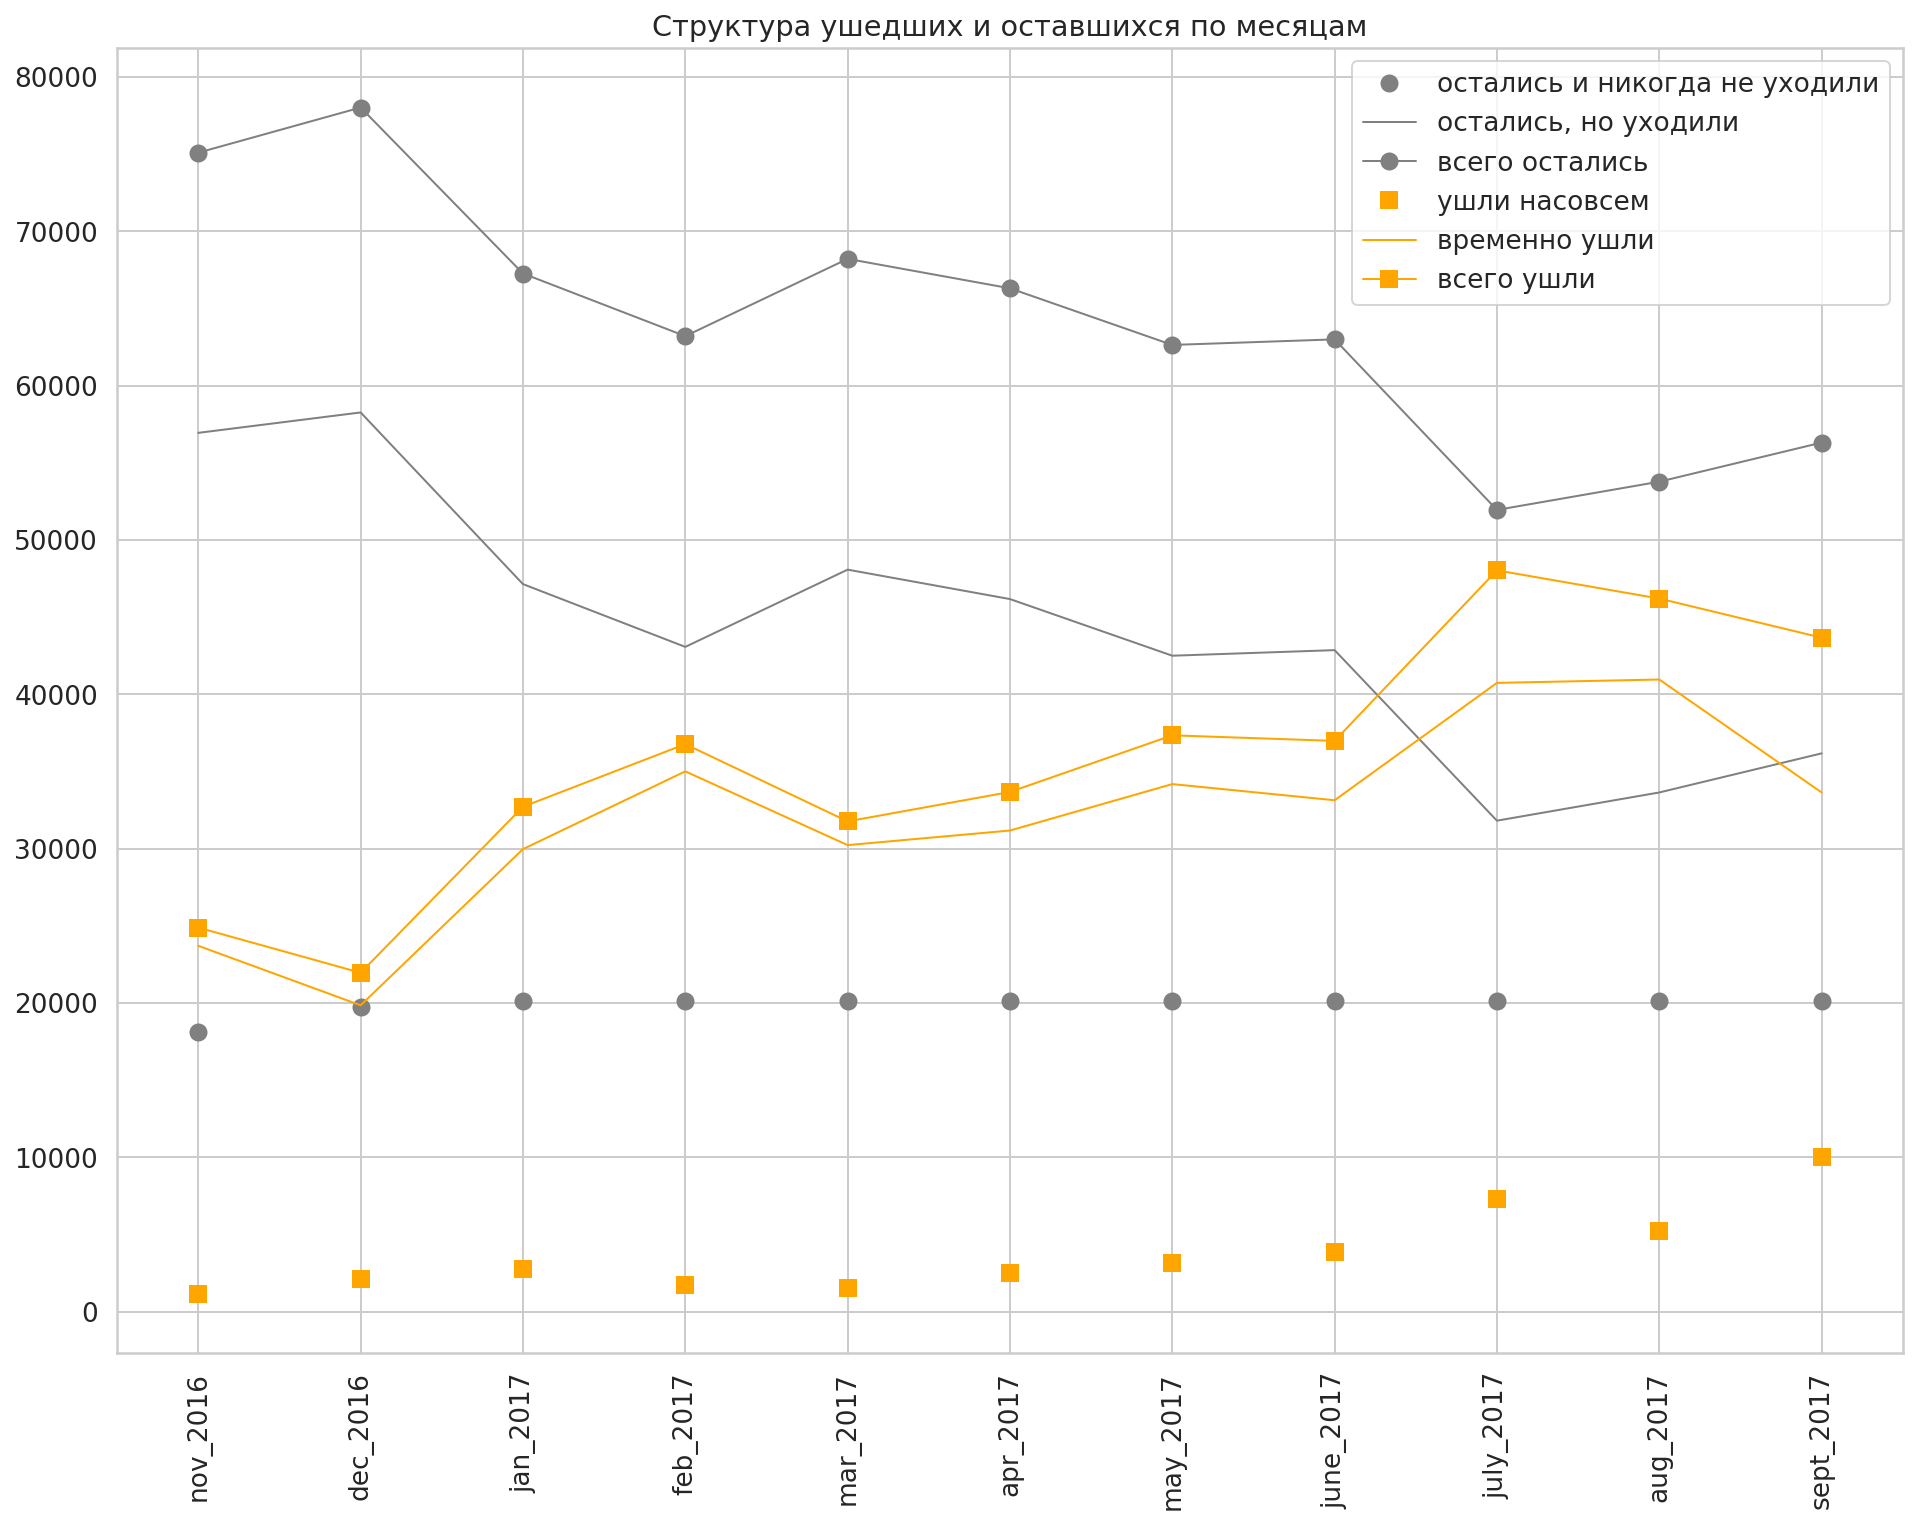

In [68]:
# Plot historical left and stay clients
plt.figure(figsize=(16, 12))

plt.plot(non_stop_active.keys(), non_stop_active.values(), 'grey', marker='o', mew=3,linewidth=0, label = 'остались и никогда не уходили')
plt.plot(stay_this_month_comeback.keys(), stay_this_month_comeback.values(), 'grey', linewidth=1, label = 'остались, но уходили')
plt.plot(stay.keys(), stay.values(), 'grey', marker='o', mew=3, linewidth=1, label = 'всего остались')

plt.plot(x, y, 'orange', marker='s', mew=3,linewidth=0,  label = 'ушли насовсем')
plt.plot(left_this_month_comeback.keys(), left_this_month_comeback.values(), 'orange', linewidth=1, label = 'временно ушли')
plt.plot(left_this_month.keys(), left_this_month.values(), 'orange', marker='s', mew=3, linewidth=1, label = 'всего ушли')

plt.xticks(x, labels, rotation='vertical')
plt.title('Структура ушедших и оставшихся по месяцам')
plt.legend();

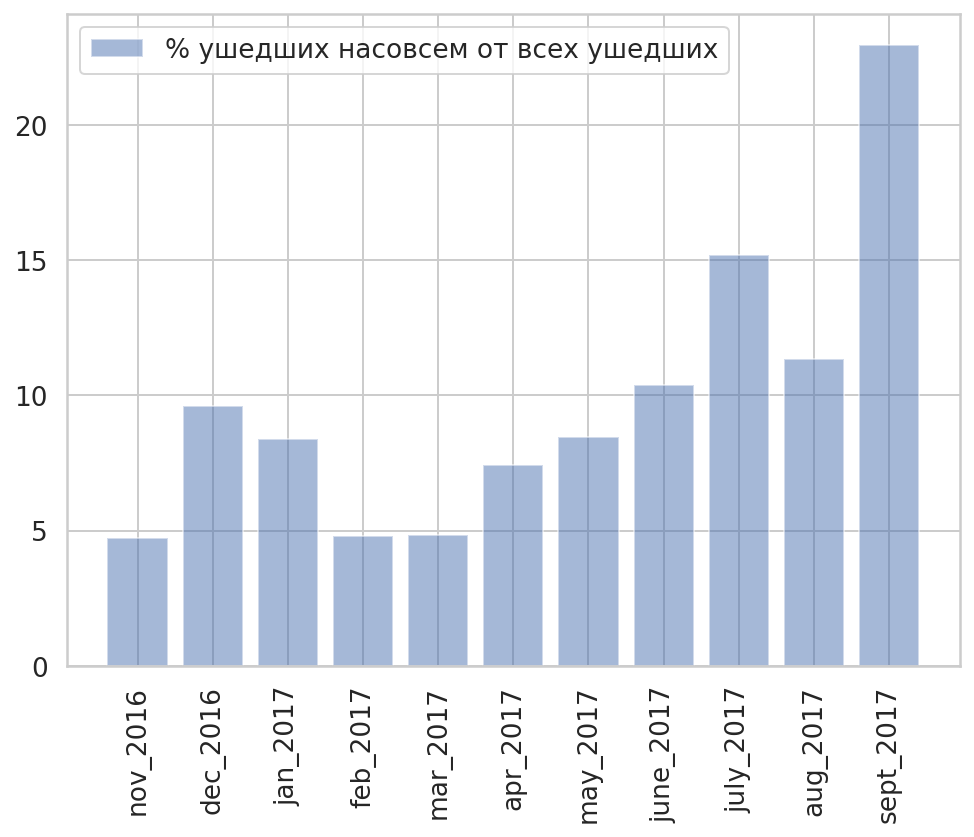

In [73]:
# Plot % left forever
percent_left_forever = []
for (left_forever, left) in zip(y, left_this_month.values()):
    percent_left_forever.append(left_forever/left*100)

plt.figure(figsize=(8, 6))
plt.bar(labels, percent_left_forever, alpha=0.5, label='% ушедших насовсем от всех ушедших')
plt.legend()
plt.xticks(rotation='vertical');

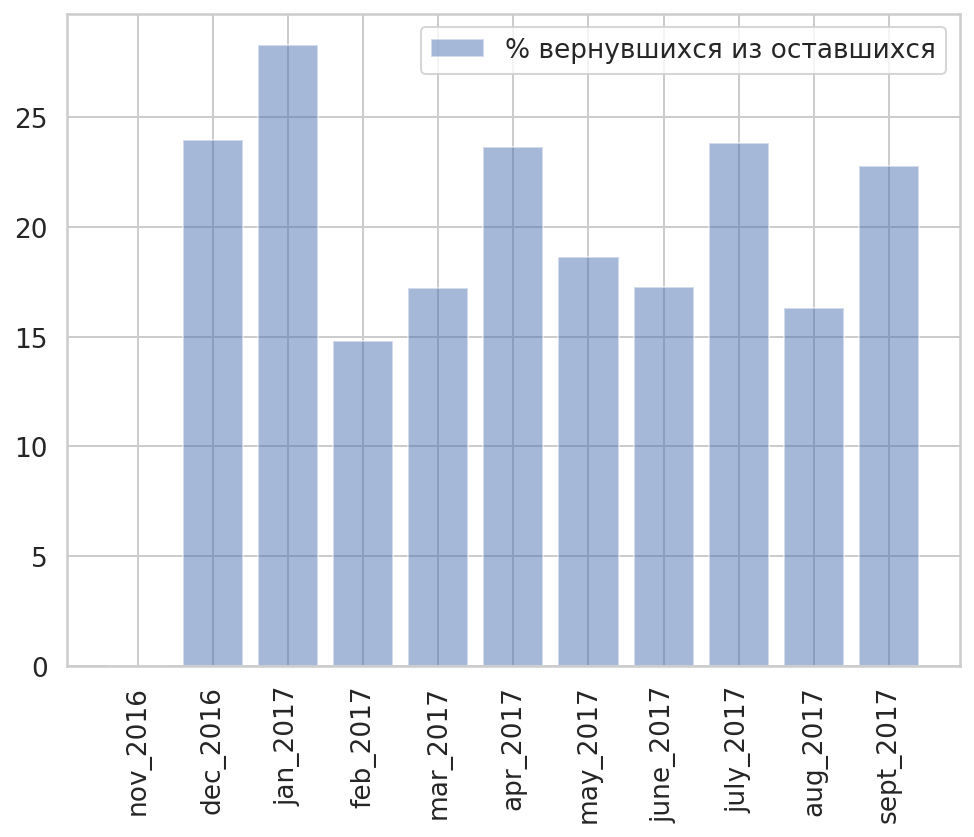

In [74]:
# % come back
come_back = []
for num in range(1,len(labels)+1):
    come_back.append(len(cb.loc[(cb.iloc[:,num-1]==0) & (cb.iloc[:,num]!=0)]))
percent_come_back = []
for (stay_, back) in zip(stay.values(), come_back):
    percent_come_back.append(back/stay_*100)

plt.figure(figsize=(8, 6))
plt.bar(labels, percent_come_back, alpha=0.5, label='% вернувшихся из оставшихся')
plt.legend()
plt.xticks(rotation='vertical');

## Prepare Left/Stay classes data

In [77]:
# Cut orders for last 34 days
orders = orders[orders['chq_date']<pd.Timestamp('2017-09-01')]

In [78]:
# Get most popular and it part in all
def most_popular_part(L):
    most_popular , most_popular_count = Counter(L).most_common(1)[0]
    return most_popular, most_popular_count/len(L)

In [79]:
# Get info about all equal
def all_equal(iterable):
    g = groupby(iterable)
    if next(g, True) and not next(g, False):
        return 1
    else:
        return 0

In [80]:
# Get some data from list of orders dates
def time_series_info(L):
    
    M = pd.Series(index = L, data = 1)
    M = M.to_frame()
    M = M.sort_index()
    last_date_order = M.index[-1]
    M = M.resample('M').sum()
    if len(M)>=2:
        M = M.iloc[:-1]
        mean_orders_per_month = M.mean()[0]
        min_orders_per_month = M.iloc[0][0]
        max_orders_per_month = M.iloc[-1][0]
        std_orders_per_month = M.std()[0]
        k_variacie_orders_per_month = std_orders_per_month/mean_orders_per_month
        count_month_with_zerro_orders = len(M[M[0]==0])
        part_month_with_zerro_orders = count_month_with_zerro_orders/len(M)
    else:
        mean_orders_per_month = M.iloc[0][0]
        min_orders_per_month = M.iloc[0][0]
        max_orders_per_month = M.iloc[0][0]
        std_orders_per_month = np.nan
        k_variacie_orders_per_month = np.nan
        count_month_with_zerro_orders = len(M[M[0]==0])
        part_month_with_zerro_orders = count_month_with_zerro_orders/len(M)
        
    if (len(M)==1) or (len(M)==2):
        diff_2_3_month_count_orders = 0
        diff_2_4_month_count_orders = 0
    elif len(M)==3:
        diff_2_3_month_count_orders = (M.iloc[-1]-M.iloc[-2])[0]
        diff_2_4_month_count_orders = 0
    else:
        diff_2_3_month_count_orders = (M.iloc[-1]-M.iloc[-2])[0]
        diff_2_4_month_count_orders = (M.iloc[-1]-M.iloc[-3])[0]

        
    return last_date_order,\
           mean_orders_per_month, min_orders_per_month, max_orders_per_month, std_orders_per_month, k_variacie_orders_per_month,\
           count_month_with_zerro_orders, count_month_with_zerro_orders,\
           diff_2_3_month_count_orders, diff_2_4_month_count_orders

In [81]:
# Get from orders all time period in months and first and last order date
max_period = round((orders['chq_date'].max()-orders['chq_date'].min()).days/30)
start_date = orders['chq_date'].min()
end_date = orders['chq_date'].max()
print('max_period: ', max_period)
print('start_date: ', start_date)
print('end_date: ', end_date)

max_period:  11
start_date:  2016-10-04 00:00:00
end_date:  2017-08-31 00:00:00


In [82]:
# Group orders to client base
%%time
cb_ = orders.groupby('client_id').agg({
    'client_gender':['first', 'count'],
    'client_city':'first',
    'client_birthyear':'first',
    'plant': [lambda x: most_popular_part(x), lambda x: all_equal(x)],
    'plant_type': ['max', lambda x: all_equal(x)],
    'plant_city': ['max', lambda x: all_equal(x)],
    'chq_date': [lambda x: time_series_info(x), lambda x: count_month_activity(x, max_period, start_date)],
    'sales_count': ['min','max','mean','std', 'sum'],
    'sales_sum': ['min','max','mean','std', 'sum'],
    'is_promo': 'mean',
    'material_is_private_label': 'mean',
    'material_is_alco': ['mean', 'max']
                           })

CPU times: user 18min 10s, sys: 1.35 s, total: 18min 11s
Wall time: 18min 11s


In [83]:
ss(cb_)

(100000, 26)
0.0552 Gb


In [84]:
# Rename columns
cb_.columns = cb_.columns.to_flat_index()
cb_.columns = ['client_gender', 'count_orders', 
               'client_city',
               'client_birthyear', 
               'plant_mp', 'one_plant_only',
               'plant_type_max', 'one_plant_type_only', 
               'plant_city_max', 'one_plant_city_only', 
               'chq_date_tsi', 'chq_date_cma', 
               'min_goods_in_cart', 'max_goods_in_cart', 'mean_goods_in_cart', 'std_goods_in_cart', 'sum_goods_in_cart', 
               'min_rub_cart', 'max_rub_cart', 'mean_rub_cart', 'std_rub_cart', 'sum_rub_cart', 
               'is_promo_mean',
               'own_brand_part', 
               'alco_mean_in_cart', 'alco_max_in_cart'
              ]

In [85]:
# Unpack to separate columns
cb_['most_popular_plant'], cb_['part_most_popular_plant'] = zip(*cb_['plant_mp'])

cb_['last_date_order'], \
cb_['mean_orders_per_month'], cb_['min_orders_per_month'], cb_['max_orders_per_month'], \
cb_['std_orders_per_month'], cb_['k_variacie_orders_per_month'], \
cb_['count_month_with_zerro_orders'], cb_['part_month_with_zerro_orders'], \
cb_['diff_2_3_month_count_orders'], cb_['diff_2_4_month_count_orders'] = zip(*cb_['chq_date_tsi'])

cb_['oct_2016'], cb_['nov_2016'], cb_['dec_2016'],\
cb_['jan_2017'], cb_['feb_2017'], cb_['mar_2017'],\
cb_['apr_2017'], cb_['may_2017'], cb_['june_2017'],\
cb_['july_2017'], cb_['aug_2017'], \
cb_['len_last_short_zerro_group'], cb_['len_max_short_zerro_group'],\
cb_['len_last_zerro_group'], cb_['len_max_zerro_group'] = zip(*cb_['chq_date_cma'])

In [86]:
# Count age
cb_.loc[:,'age_client_last_order'] = cb_['last_date_order'].dt.year.astype(float) - cb_['client_birthyear']

In [87]:
# Marker same city
cb_['same_city'] = 0
cb_.loc[cb_['client_city'] == cb_['plant_city_max'], 'same_city'] = 1

In [88]:
# Remove columns
cb_ = cb_.drop(['plant_mp', 'chq_date_tsi', 'chq_date_cma'], axis=1)

In [89]:
# Add type column
cb_['type'] = cb['type']

In [90]:
# Save
cb_.to_csv('cb_.csv')

## Left/Stay classes data analise

In [208]:
# Load
cb = pd.read_csv('cb_.csv')

In [209]:
# Drop -1 class
cb = cb[(cb['type']==0) | (cb['type']==1)] 

In [210]:
# Check correlation
corr = cb.corr()
corr.style.background_gradient(cmap='coolwarm')

In [211]:
# Choose best columns
best_columns =  ['count_orders',
                 'one_plant_only', 'one_plant_type_only', \
                 'min_goods_in_cart', 'max_goods_in_cart', 'sum_goods_in_cart', \
                 'min_rub_cart', 'max_rub_cart', 'sum_rub_cart', \
                 'alco_max_in_cart', \
                 'mean_orders_per_month', 'min_orders_per_month', 'max_orders_per_month', 'std_orders_per_month', 'k_variacie_orders_per_month', \
                 'count_month_with_zerro_orders', 'part_month_with_zerro_orders', \
                 'oct_2016', 'nov_2016', 'dec_2016', 'jan_2017', 'feb_2017', 'mar_2017', 'apr_2017', 'may_2017', 'june_2017', 'july_2017', 'aug_2017',\
                 'len_last_short_zerro_group', 'len_max_short_zerro_group', 'len_last_zerro_group', 'len_max_zerro_group',\
                 'type']
cb = cb[best_columns]

In [212]:
# Add duplicate data
cb = pd.concat([cb, cb[cb['type']==0]], sort=False, axis=0)
cb = cb.reset_index(drop=True)

In [213]:
# Delite some data
del_id = random.choices(list(cb[cb['type']==1].index), k=(cb['type'].value_counts()[1] - cb['type'].value_counts()[0]))
cb = cb.loc[list(set(cb.index)-set(del_id))]

In [214]:
cb['type'].value_counts()

1    40291
0    40274
Name: type, dtype: int64

In [215]:
# Count mean by type
means_by_type = cb.groupby('type').mean()
means_by_type

count_orders  one_plant_only  one_plant_type_only  min_goods_in_cart  \
type                                                                         
0        63.813527        0.329145             0.731638           0.353865   
1        13.794445        0.521506             0.852349           2.939582   

      max_goods_in_cart  sum_goods_in_cart  min_rub_cart  max_rub_cart  \
type                                                                     
0             56.467338         925.414807    -81.564046   5697.203244   
1             36.592779         188.177923    255.512261   3660.195269   

      sum_rub_cart  alco_max_in_cart  mean_orders_per_month  \
type                                                          
0     83253.333728          0.535378               5.848607   
1     17900.349219          0.250937               1.965630   

      min_orders_per_month  max_orders_per_month  std_orders_per_month  \
type                                                                     
0                 5.113622              5.783930              2.664349   
1                 2.622000              1.663945              1.540319   

      k_variacie_orders_per_month  count_month_with_zerro_orders  \
type                                                               
0                        0.483422                       0.000000   
1                        1.076643                       2.123427   

      part_month_with_zerro_orders  oct_2016  nov_2016  dec_2016  jan_2017  \
type                                                                         
0                         0.000000  4.771068  5.349208  5.883796  5.763719   
1                         2.123427  1.699610  1.762677  1.941625  1.446651   

      feb_2017  mar_2017  apr_2017  may_2017  june_2017  july_2017  aug_2017  \
type                                                                           
0     5.377266  6.439936  6.115707  6.118836   6.335055   5.783930  5.875006   
1     1.201385  1.435457  1.203792  1.065821   1.002283   0.562185  0.472959   

      len_last_short_zerro_group  len_max_short_zerro_group  \
type                                                          
0                       0.000000                    0.00000   
1                       1.437517                    1.60135   

      len_last_zerro_group  len_max_zerro_group  
type                                             
0                 0.117694             0.117694  
1                 3.618898             3.989799

In [216]:
cb.loc[(cb['type']==0) & (cb['min_goods_in_cart']>0)]['min_goods_in_cart'].mean()

1.2648306491885144

In [217]:
cb.loc[(cb['type']==1) & (cb['min_goods_in_cart']>0)]['min_goods_in_cart'].mean()

3.3468239274668923

In [218]:
cb.loc[(cb['type']==0) & (cb['min_rub_cart']<200) & (cb['min_rub_cart']>0)]['min_rub_cart'].mean()

59.43288522961175

In [219]:
cb.loc[(cb['type']==1) & (cb['min_rub_cart']<200) & (cb['min_rub_cart']>0)]['min_rub_cart'].mean()

82.88931620464278

In [220]:
# у оставшихся среднее минимальное количество товаров корзине ниже в 2.5 раза (только для положительных значений значений)
# у оставшихся боше среднее максимальное число товаров в корзине в 1.5 раза
# у оставшихся средний минимальный чек меньше почти на 24р (если минимальный чек до 200р)
# максимальный средний чек у оставшихся больше чем у ушедших почти на 2000р
# средний чек у оставшихся почти в 5 раза больше, чем у ушедших

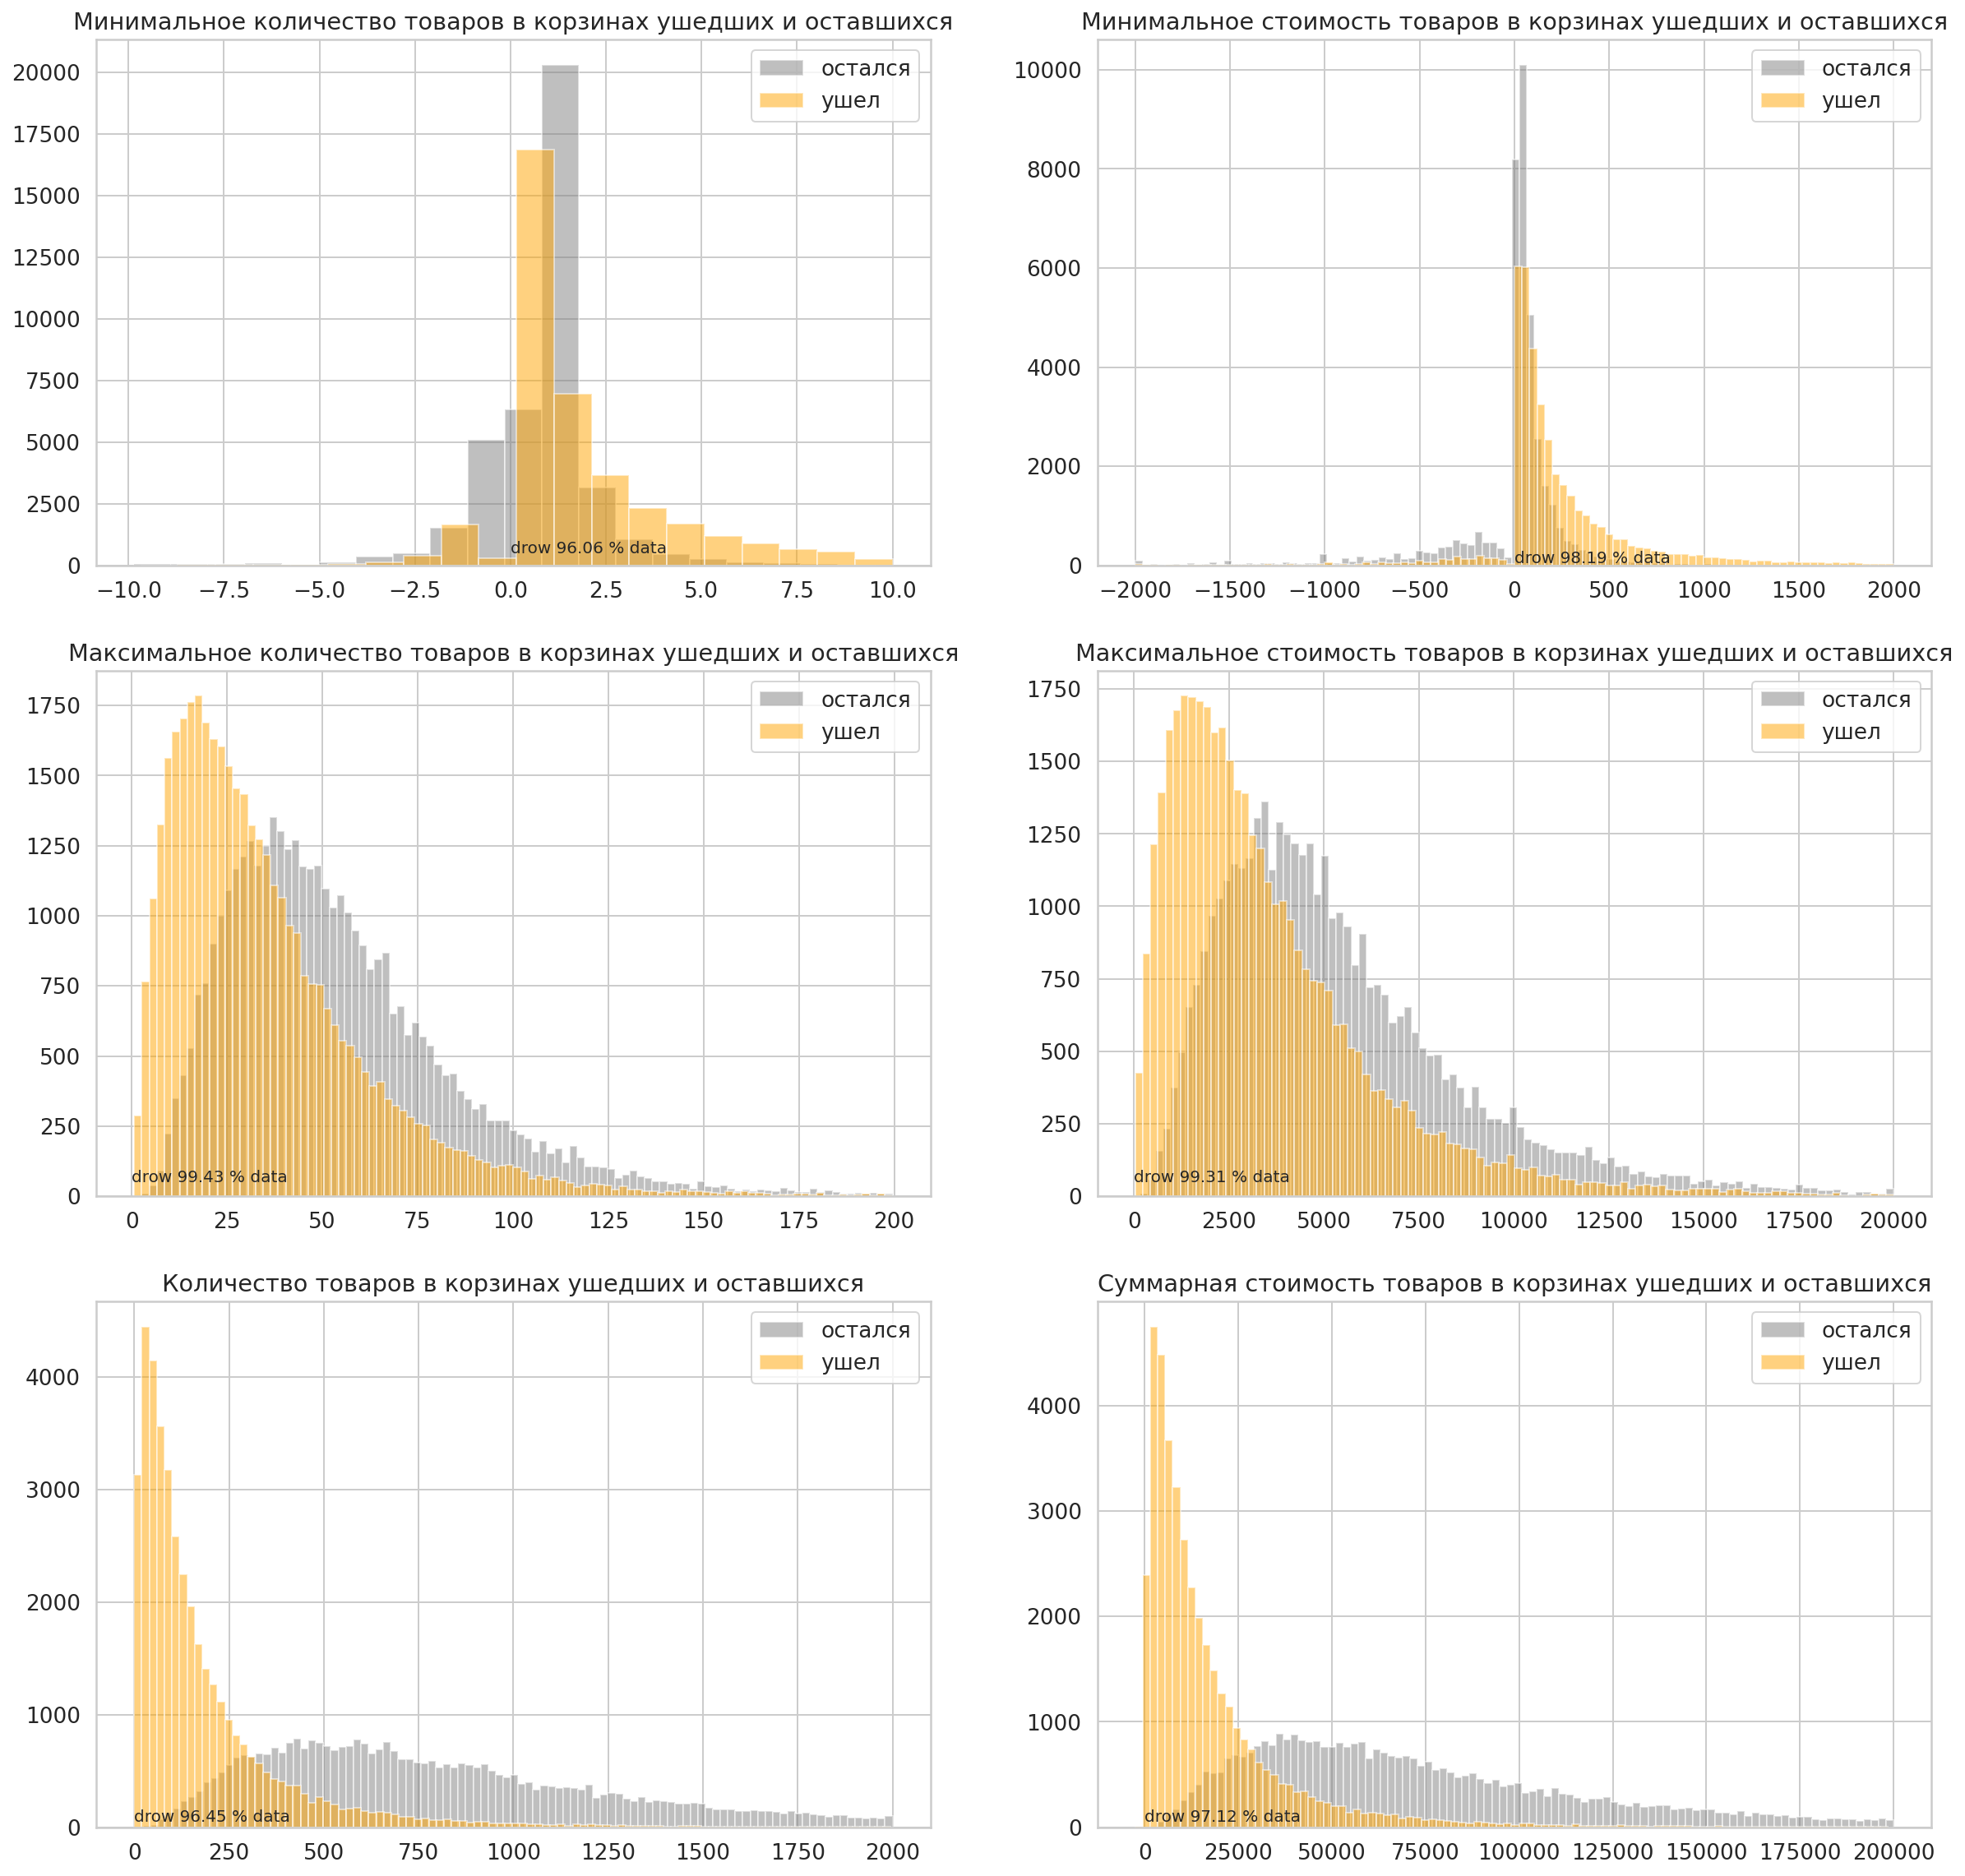

In [221]:
# Plot hists
not_drow_proc_00 = len(cb.loc[(cb['min_goods_in_cart']<10) & (cb['min_goods_in_cart']>-10)])/len(cb)*100
not_drow_proc_10 = len(cb.loc[cb['max_goods_in_cart']<200])/len(cb)*100
not_drow_proc_20 = len(cb.loc[cb['sum_goods_in_cart']<2000])/len(cb)*100
not_drow_proc_01 = len(cb.loc[(cb['min_rub_cart']<2000) & (cb['min_rub_cart']>-2000)])/len(cb)*100
not_drow_proc_11 = len(cb.loc[cb['max_rub_cart']<20000])/len(cb)*100
not_drow_proc_21 = len(cb.loc[cb['sum_rub_cart']<200000])/len(cb)*100

fig, axs = plt.subplots(3, 2, figsize=(20, 20))

axs[0, 0].text(0, 500, f'drow {not_drow_proc_00:.2f} % data')
axs[1, 0].text(0, 50, f'drow {not_drow_proc_10:.2f} % data')
axs[2, 0].text(0, 50, f'drow {not_drow_proc_20:.2f} % data')
axs[0, 1].text(0, 50, f'drow {not_drow_proc_01:.2f} % data')
axs[1, 1].text(0, 50, f'drow {not_drow_proc_11:.2f} % data')
axs[2, 1].text(0, 50, f'drow {not_drow_proc_21:.2f} % data')

axs[0, 0].hist(cb.loc[(cb['type']==0) & (cb['min_goods_in_cart']<10) & (cb['min_goods_in_cart']>-10)]['min_goods_in_cart'], bins=20, alpha=0.5, color='grey', label='остался')
axs[0, 0].hist(cb.loc[(cb['type']==1) & (cb['min_goods_in_cart']<10) & (cb['min_goods_in_cart']>-10)]['min_goods_in_cart'], bins=20, alpha=0.5, color='orange', label='ушел')
axs[1, 0].hist(cb.loc[(cb['type']==0) & (cb['max_goods_in_cart']<200) ]['max_goods_in_cart'], bins=100, alpha=0.5, color='grey', label='остался')
axs[1, 0].hist(cb.loc[(cb['type']==1) & (cb['max_goods_in_cart']<200) ]['max_goods_in_cart'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[2, 0].hist(cb.loc[(cb['type']==0) & (cb['sum_goods_in_cart']<2000) ]['sum_goods_in_cart'], bins=100, alpha=0.5, color='grey', label='остался')
axs[2, 0].hist(cb.loc[(cb['type']==1) & (cb['sum_goods_in_cart']<2000) ]['sum_goods_in_cart'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[0, 1].hist(cb.loc[(cb['type']==0) & (cb['min_rub_cart']<2000) & (cb['min_rub_cart']>-2000)]['min_rub_cart'], bins=100, alpha=0.5, color='grey', label='остался')
axs[0, 1].hist(cb.loc[(cb['type']==1) & (cb['min_rub_cart']<2000) & (cb['min_rub_cart']>-2000)]['min_rub_cart'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[1, 1].hist(cb.loc[(cb['type']==0) & (cb['max_rub_cart']<20000)]['max_rub_cart'], bins=100, alpha=0.5, color='grey', label='остался')
axs[1, 1].hist(cb.loc[(cb['type']==1) & (cb['max_rub_cart']<20000) ]['max_rub_cart'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[2, 1].hist(cb.loc[(cb['type']==0) & (cb['sum_rub_cart']<200000)]['sum_rub_cart'], bins=100, alpha=0.5, color='grey', label='остался')
axs[2, 1].hist(cb.loc[(cb['type']==1) & (cb['sum_rub_cart']<200000)]['sum_rub_cart'], bins=100, alpha=0.5, color='orange', label='ушел')

axs[0, 0].set_title('Минимальное количество товаров в корзинах ушедших и оставшихся')
axs[1, 0].set_title('Максимальное количество товаров в корзинах ушедших и оставшихся')
axs[2, 0].set_title('Количество товаров в корзинах ушедших и оставшихся')
axs[0, 1].set_title('Минимальное стоимость товаров в корзинах ушедших и оставшихся')
axs[1, 1].set_title('Максимальное стоимость товаров в корзинах ушедших и оставшихся')
axs[2, 1].set_title('Суммарная стоимость товаров в корзинах ушедших и оставшихся')

axs[0, 0].legend()
axs[1, 0].legend()
axs[2, 0].legend()
axs[0, 1].legend()
axs[1, 1].legend()
axs[2, 1].legend();

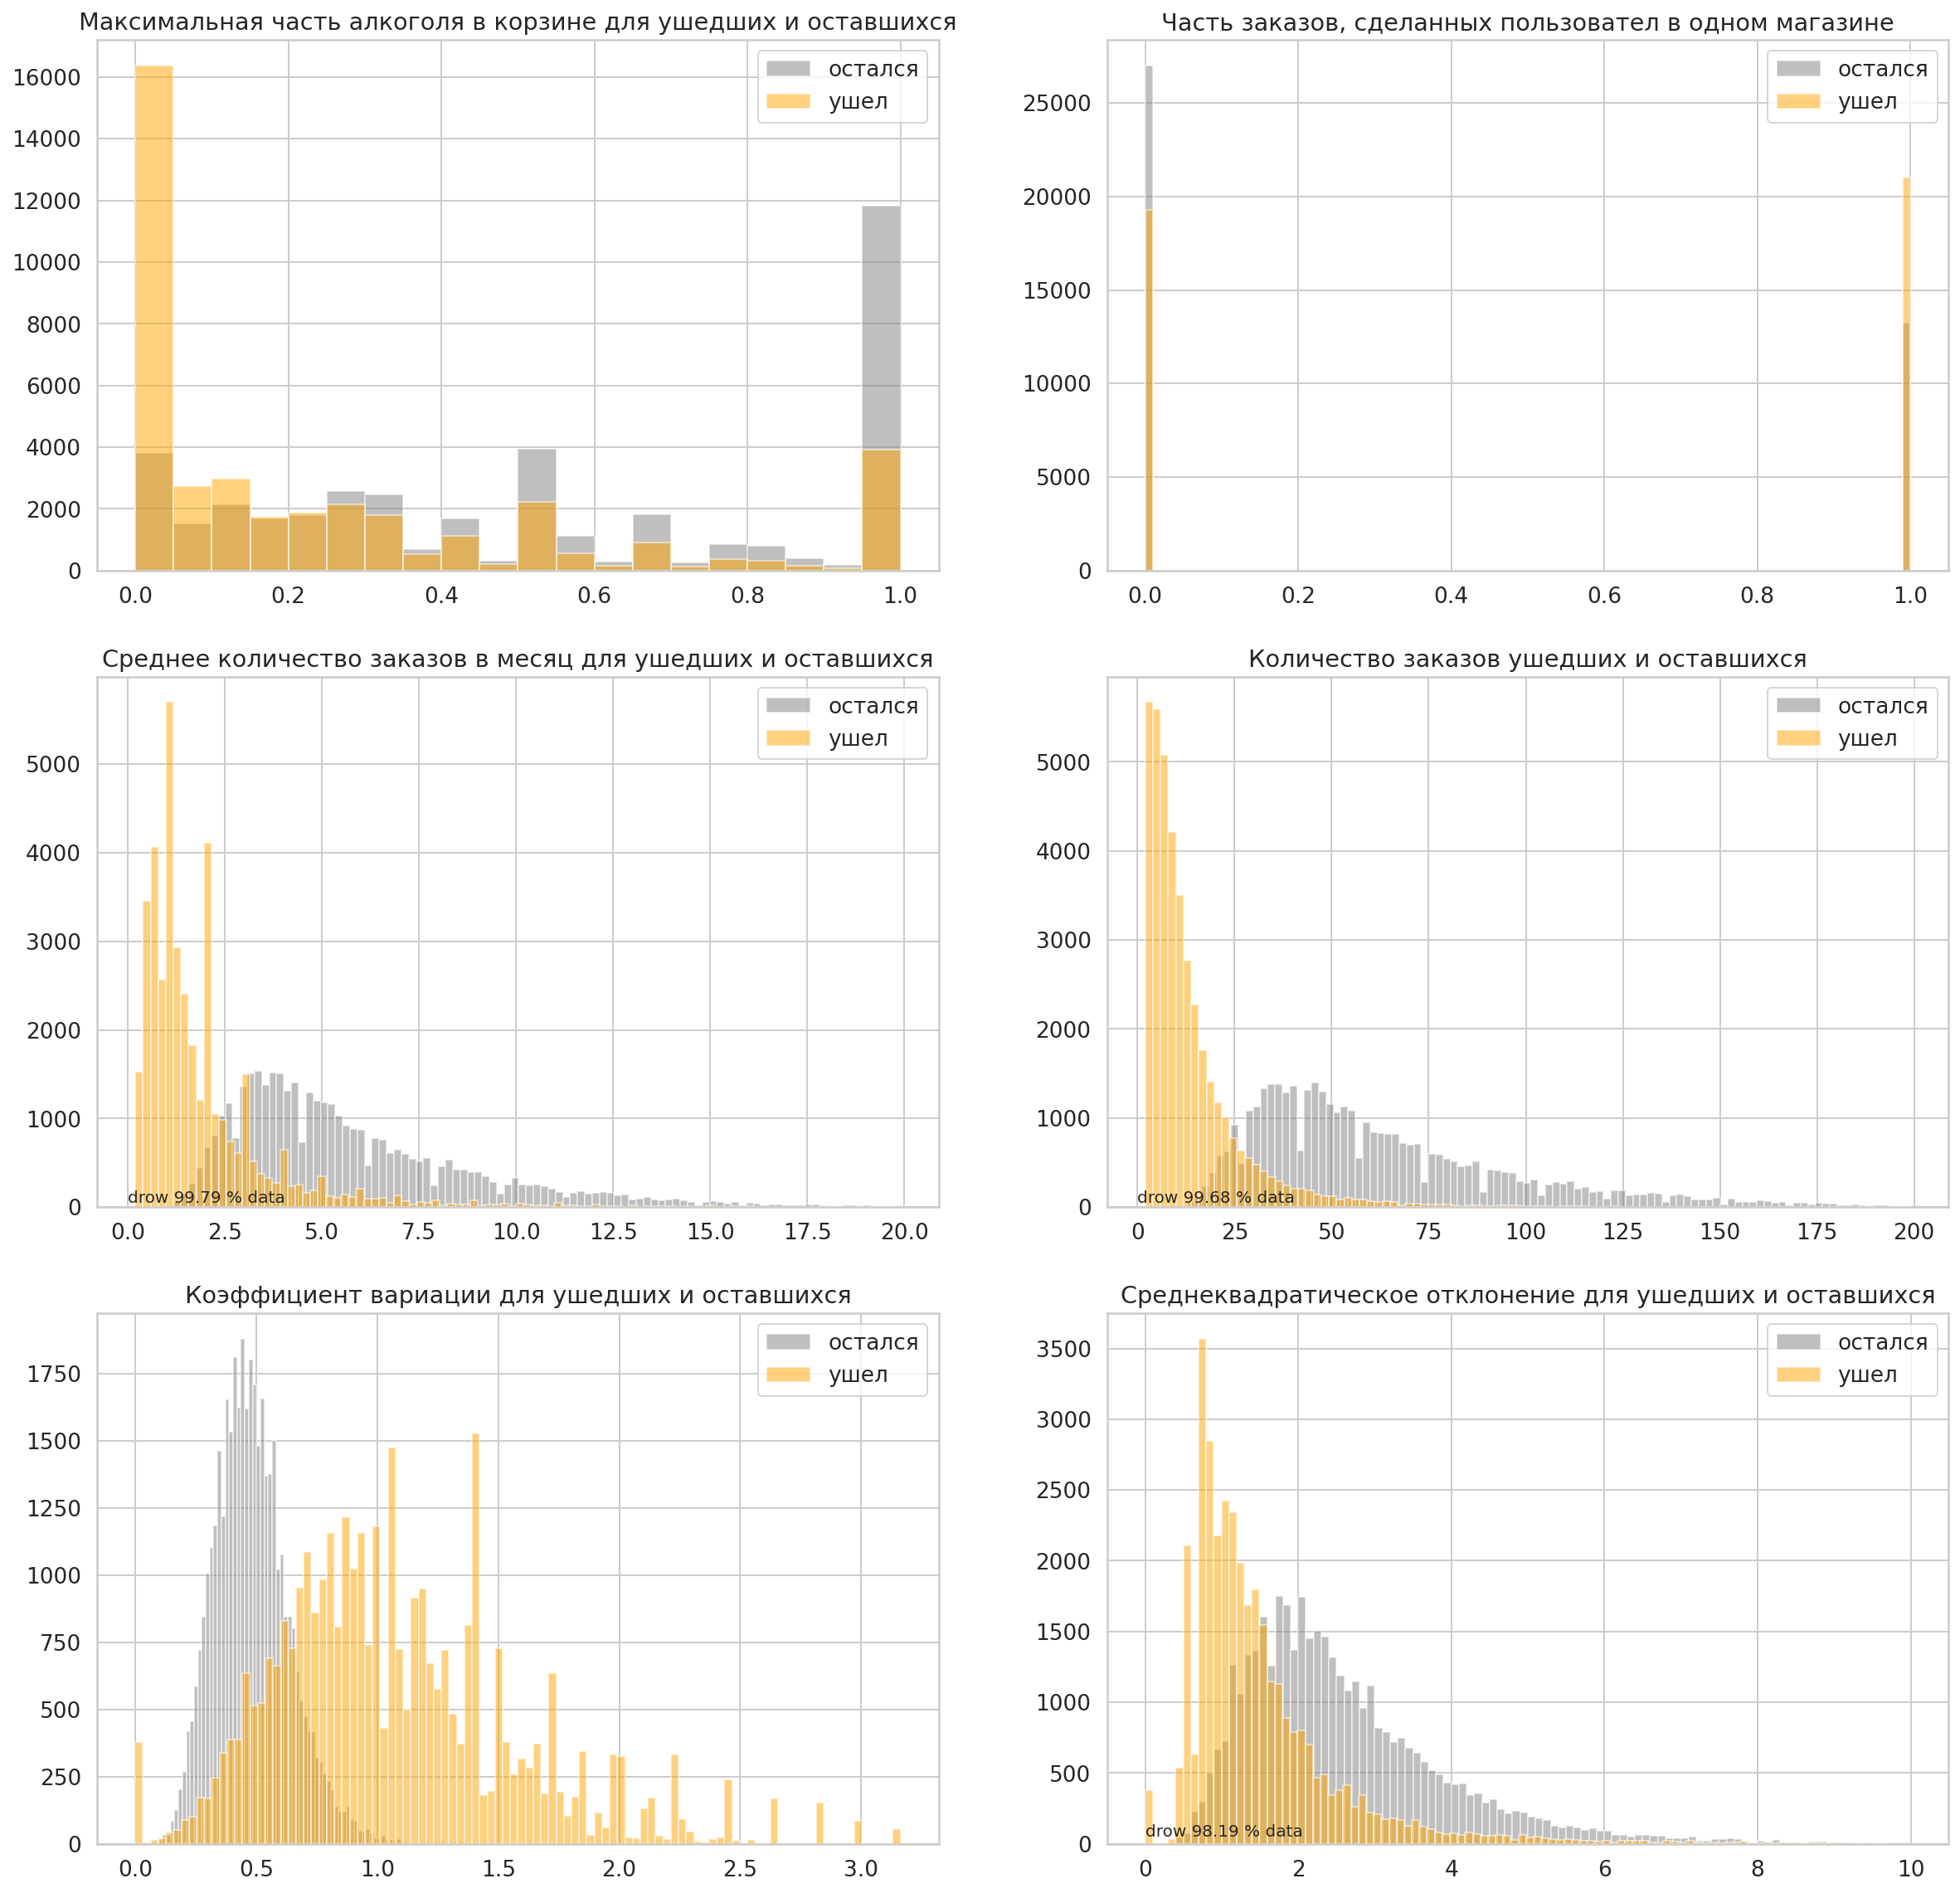

In [222]:
# Plot hists
not_drow_proc_21 = len(cb.loc[(cb['std_orders_per_month']<10)])/len(cb)*100
not_drow_proc_10 = len(cb.loc[(cb['mean_orders_per_month']<20)])/len(cb)*100
not_drow_proc_11 = len(cb.loc[(cb['count_orders']<200)])/len(cb)*100

fig, axs = plt.subplots(3, 2, figsize=(20, 20))

axs[1, 0].text(0, 50, f'drow {not_drow_proc_10:.2f} % data')
axs[1, 1].text(0, 50, f'drow {not_drow_proc_11:.2f} % data')
axs[2, 1].text(0, 50, f'drow {not_drow_proc_01:.2f} % data')

axs[0, 0].hist(cb.loc[(cb['type']==0)]['alco_max_in_cart'], bins=20, alpha=0.5, color='grey', label='остался')
axs[0, 0].hist(cb.loc[(cb['type']==1)]['alco_max_in_cart'], bins=20, alpha=0.5, color='orange', label='ушел')
axs[1, 0].hist(cb.loc[(cb['type']==0) & (cb['mean_orders_per_month']<20) ]['mean_orders_per_month'], bins=100, alpha=0.5, color='grey', label='остался')
axs[1, 0].hist(cb.loc[(cb['type']==1) & (cb['mean_orders_per_month']<20) ]['mean_orders_per_month'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[2, 0].hist(cb.loc[(cb['type']==0)]['k_variacie_orders_per_month'], bins=100, alpha=0.5, color='grey', label='остался')
axs[2, 0].hist(cb.loc[(cb['type']==1)]['k_variacie_orders_per_month'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[0, 1].hist(cb.loc[(cb['type']==0)]['one_plant_only'], bins=100, alpha=0.5, color='grey', label='остался')
axs[0, 1].hist(cb.loc[(cb['type']==1)]['one_plant_only'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[1, 1].hist(cb.loc[(cb['type']==0) & (cb['count_orders']<200)]['count_orders'], bins=100, alpha=0.5, color='grey', label='остался')
axs[1, 1].hist(cb.loc[(cb['type']==1) & (cb['count_orders']<200) ]['count_orders'], bins=100, alpha=0.5, color='orange', label='ушел')
axs[2, 1].hist(cb.loc[(cb['type']==0) & (cb['std_orders_per_month']<10)]['std_orders_per_month'], bins=100, alpha=0.5, color='grey', label='остался')
axs[2, 1].hist(cb.loc[(cb['type']==1) & (cb['std_orders_per_month']<10)]['std_orders_per_month'], bins=100, alpha=0.5, color='orange', label='ушел')

axs[0, 0].set_title('Максимальная часть алкоголя в корзине для ушедших и оставшихся')
axs[1, 0].set_title('Среднее количество заказов в месяц для ушедших и оставшихся')
axs[2, 0].set_title('Коэффициент вариации для ушедших и оставшихся')
axs[0, 1].set_title('Часть заказов, сделанных пользовател в одном магазине')
axs[1, 1].set_title('Количество заказов ушедших и оставшихся')
axs[2, 1].set_title('Среднеквадратическое отклонение для ушедших и оставшихся')

axs[0, 0].legend()
axs[1, 0].legend()
axs[2, 0].legend()
axs[0, 1].legend()
axs[1, 1].legend()
axs[2, 1].legend();

In [223]:
# люди, которые хоть раз купили только алкоголь, возвращаются чаще почти в 3 раза.
# наоборот, люди, совсем без алкоголя в корзинах, возвращаются почти в 5 раза реже.
# коэффициент вариации среднего количества покупок по месяцам у оставшихся меньше, чем у ушедших
# покупающие в одном и том же магазине остаются чаще в 2 раза, чем пкупающие в разных

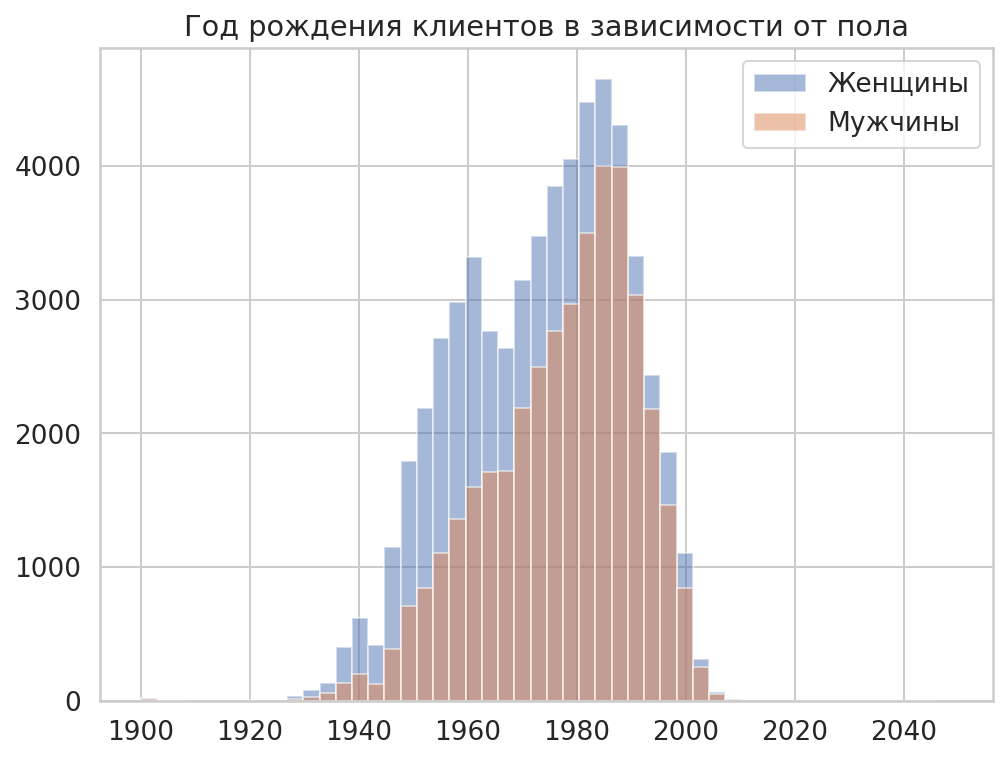

In [224]:
plt.figure(num=None, figsize=(8, 6))
plt.hist(clients.loc[clients['client_gender']=='F']['client_birthyear'], bins=50, alpha=0.5, label='Женщины')
plt.hist(clients.loc[clients['client_gender']=='M']['client_birthyear'], bins=50, alpha=0.5, label='Мужчины')
plt.title('Год рождения клиентов в зависимости от пола')
plt.legend();

In [226]:
# женщин которые родились в 1940 или 1960 в базе больше, чем остальных (причины неизвестны)

## Left/Stay classification research

In [306]:
# Imports
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

In [233]:
# Fill nan values
cb.loc[(cb['k_variacie_orders_per_month'].isna()) & (cb['type']==0), 'k_variacie_orders_per_month'] = means_by_type.loc[0,'k_variacie_orders_per_month']
cb.loc[(cb['k_variacie_orders_per_month'].isna()) & (cb['type']==1), 'k_variacie_orders_per_month'] = means_by_type.loc[1,'k_variacie_orders_per_month']
cb.loc[(cb['std_orders_per_month'].isna()) & (cb['type']==0), 'std_orders_per_month'] = means_by_type.loc[0,'std_orders_per_month']
cb.loc[(cb['std_orders_per_month'].isna()) & (cb['type']==1), 'std_orders_per_month'] = means_by_type.loc[1,'std_orders_per_month']

In [234]:
X = cb[['count_orders', 'one_plant_only', 'one_plant_type_only',
       'min_goods_in_cart', 'max_goods_in_cart', 'sum_goods_in_cart',
       'min_rub_cart', 'max_rub_cart', 'sum_rub_cart', 'alco_max_in_cart',
       'mean_orders_per_month', 'min_orders_per_month', 'max_orders_per_month',
       'std_orders_per_month', 'k_variacie_orders_per_month',
       'count_month_with_zerro_orders', 'part_month_with_zerro_orders',
       'oct_2016', 'nov_2016', 'dec_2016', 'jan_2017', 'feb_2017', 'mar_2017',
       'apr_2017', 'may_2017', 'june_2017', 'july_2017', 'aug_2017',
       'len_last_short_zerro_group', 'len_max_short_zerro_group',
       'len_last_zerro_group', 'len_max_zerro_group']]

In [177]:
# Scale data
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [238]:
# Get Y
Y = cb['type']

In [239]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [180]:
# Check Gaussian Naive Bayes
gaus = GaussianNB()
gaus = gaus.fit(X_train ,y_train)
gaus.score(X_test, y_test)

0.9577954319761668

In [181]:
# Check Support Vector Machines
clf = SVC()
clf = clf.fit(X_train ,y_train)
clf.score(X_test, y_test)

0.9800459285004965

In [240]:
# Check RandomForest
rf = RF()
rf = rf.fit(X_train ,y_train)
rf.score(X_test, y_test)

0.983429528951778

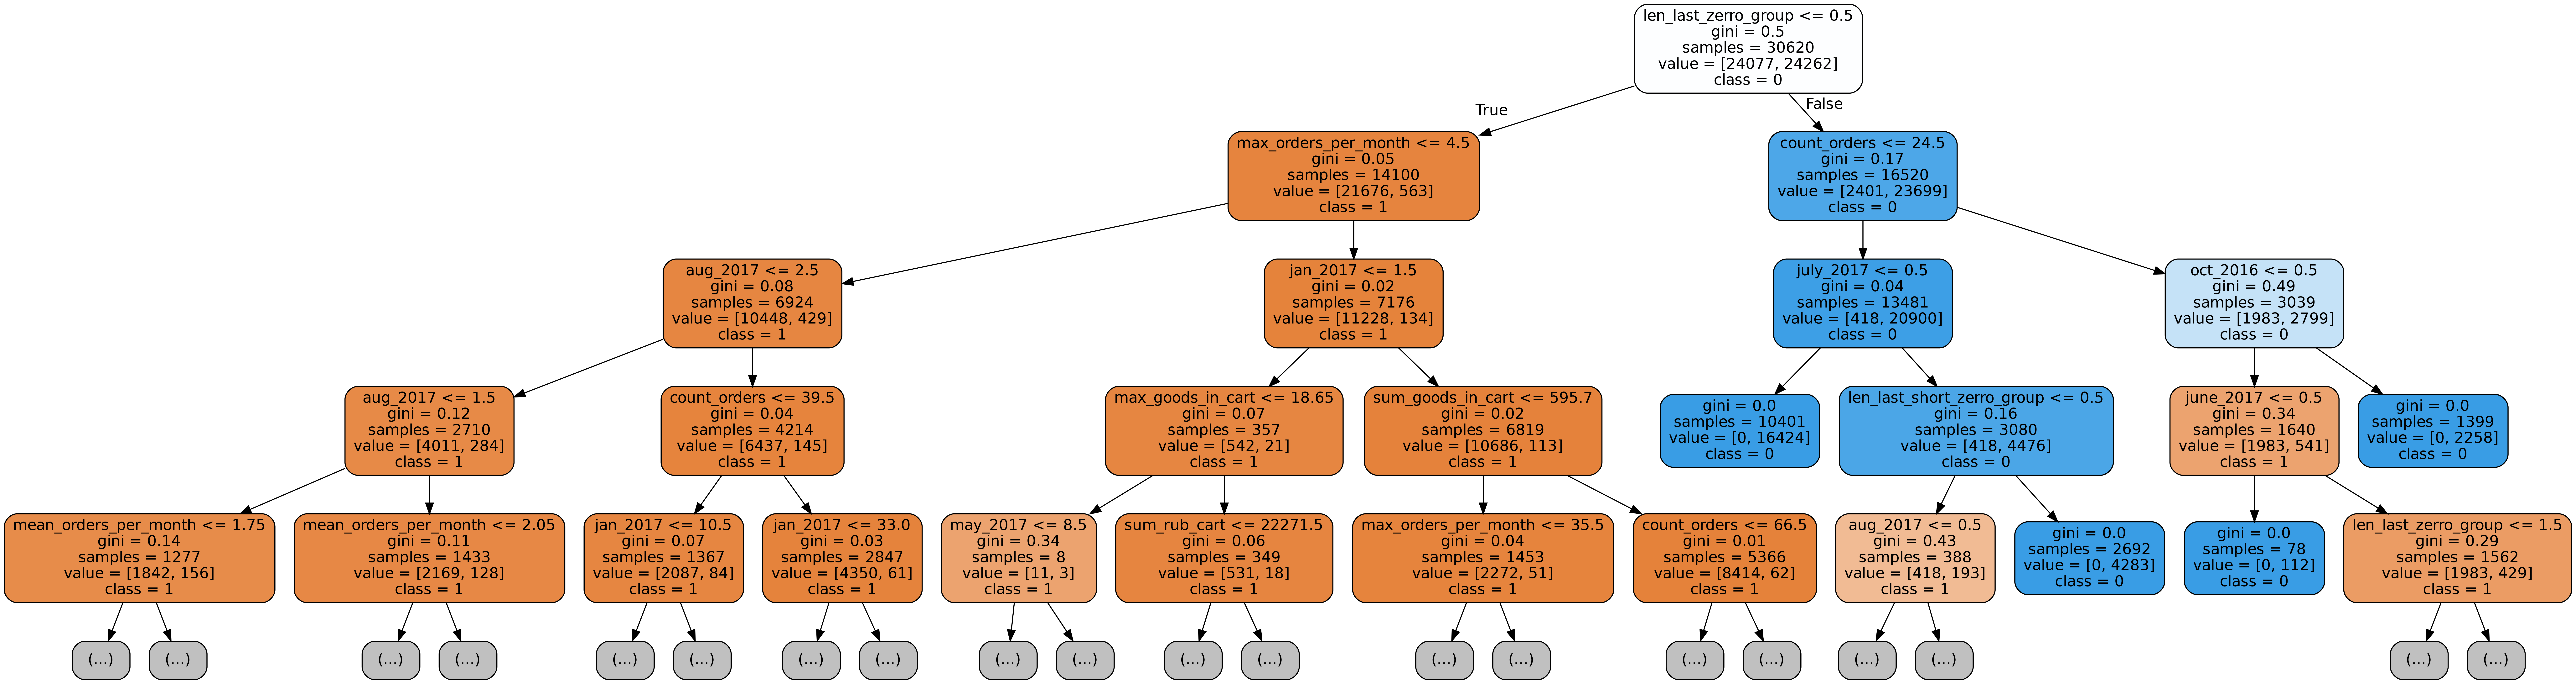

In [246]:
# Draw part of random tree (10 from 0..100)
export_graphviz(rf[6], out_file='tree.dot',
                max_depth = 4,
                feature_names = list(cb.drop('type', axis=1).columns),
                class_names = (Y.unique()).astype('str'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=400'])
Image(filename = 'tree.png')

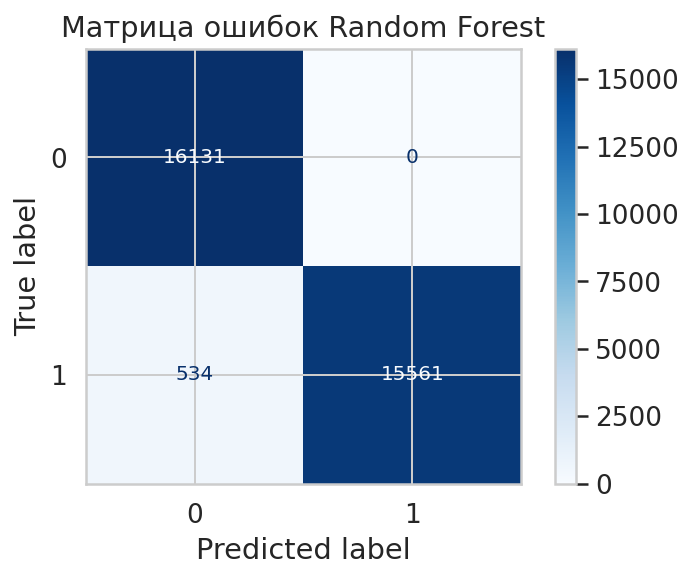

In [247]:
# Draw confusion matrix
disp = plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues);
disp.ax_.set_title('Матрица ошибок Random Forest');

In [248]:
# Add predict label to cb
cb['type_pred'] = rf.predict(cb.drop('type', axis=1).values)

In [249]:
# Marker wrong classifier data
cb['wrong'] = 0
cb.loc[cb['type']!=cb['type_pred'], 'wrong'] = 1

In [272]:
# Choose random data from cb for compare 
df = pd.concat([cb[cb['wrong']==1],\
                cb.loc[random.choices(list(cb[cb['type']==1].index), k=(len(cb[cb['wrong']==1])))],\
                cb.loc[random.choices(list(cb[cb['type']==0].index), k=(len(cb[cb['wrong']==1])))]], sort=False, axis=0)

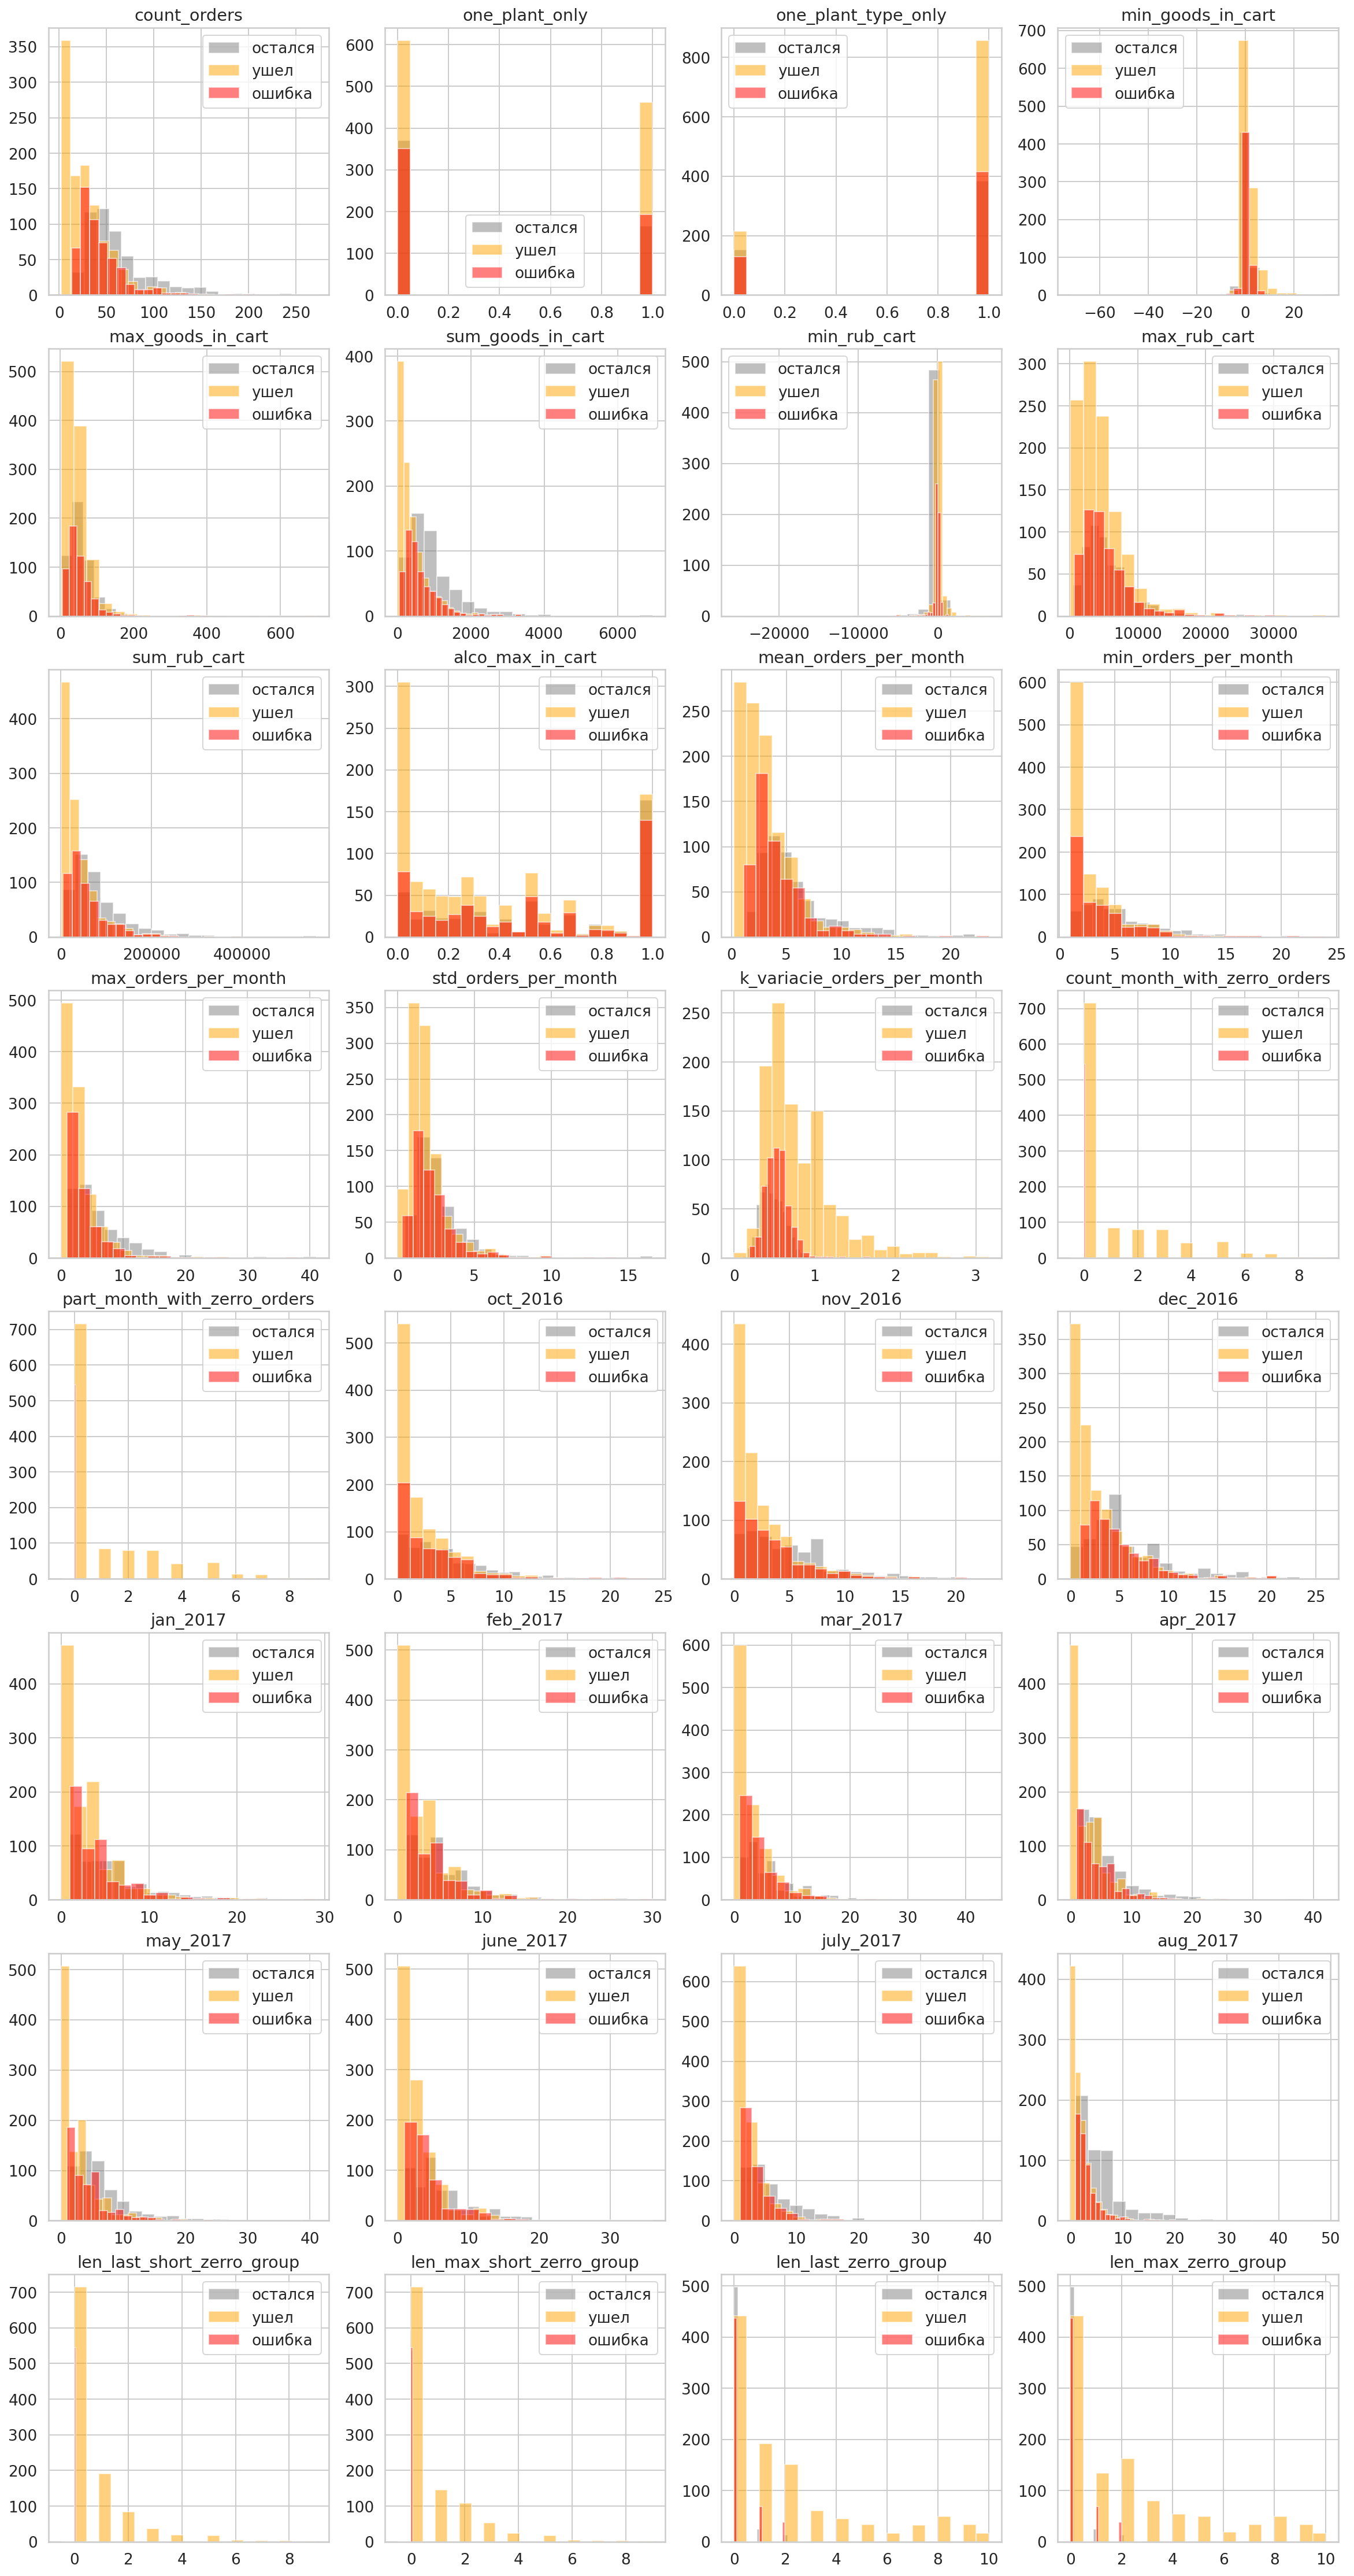

In [273]:
# Plot hists
fig, axs = plt.subplots(8, 4, figsize=(20, 40))
x = 0
y = 0
for col in df.drop(['type', 'type_pred', 'wrong'], axis=1).columns:
    axs[x, y].hist(df.loc[(df['type']==0) ][col], bins=20, alpha=0.5, color='grey', label='остался')
    axs[x, y].hist(df.loc[(df['type']==1) ][col], bins=20, alpha=0.5, color='orange', label='ушел')
    axs[x, y].hist(df.loc[(df['wrong']==1)][col], bins=20, alpha=0.5, color='red', label='ошибка')
    axs[x, y].set_title(col)
    axs[x, y].legend();
    y = y + 1
    if y == 4:
        y = 0
        x = x + 1

In [ ]:
# Подробное изучение ошибок не дали простого ответа на то, как этих ошибок избежать.
# Подбор гирперпараметров для RandomForest или переход на xgboost не дали ожидаемых эффектов
# Конечный алгоритм - RandomForest с точнностью '100%' и полнотой 98.67%

In [302]:
score = rf.score(X_test, y_test)*100
f'{score:.2f}%'

'98.34%'

In [303]:
recall = recall_score(cb['type'], cb['type_pred'])*100
f'{recall:.2f}%'

'98.67%'

In [305]:
precision = precision_score(cb['type'], cb['type_pred'])*100
f'{precision:.2f}%'

'100.00%'